<a href="https://colab.research.google.com/github/shambakey1/water_pollution/blob/main/solving_ADE_using_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ADE Solver — Variable-Coefficient Advection-Diffusion-Decay

[1] Variable-coeff FD solve completed in 0.0021 s
    Grid: Nx=11, Nt=31  |  C range: [0.036788, 1.100000]

[2] Constant-coeff FD solve completed in 0.0021 s

[3] Validation (constant-coeff, t=0.06):
    L2 error  = 8.715827e-03
    L∞ error  = 1.845339e-02

[4] Generating figures …


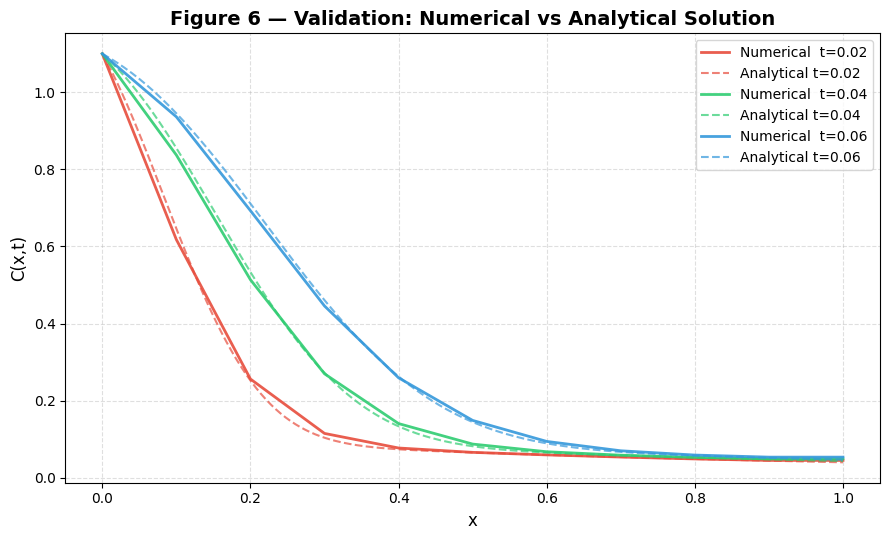

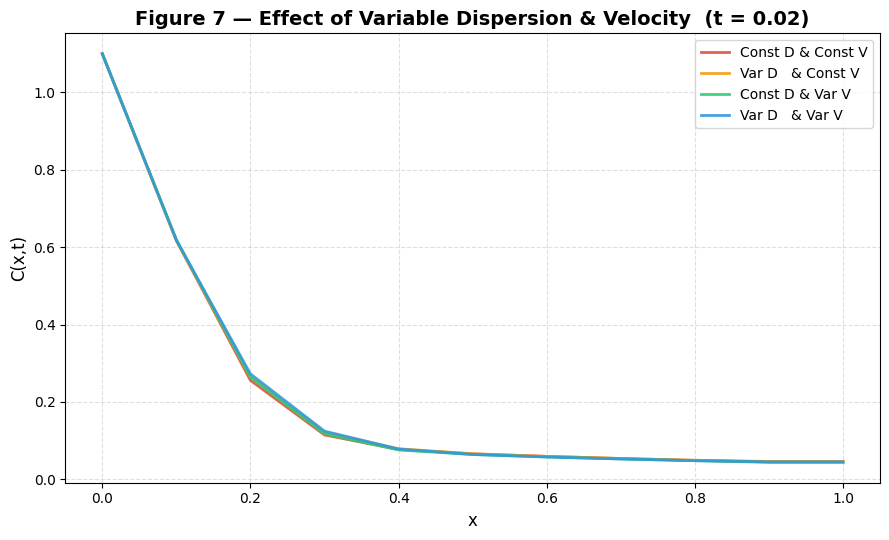

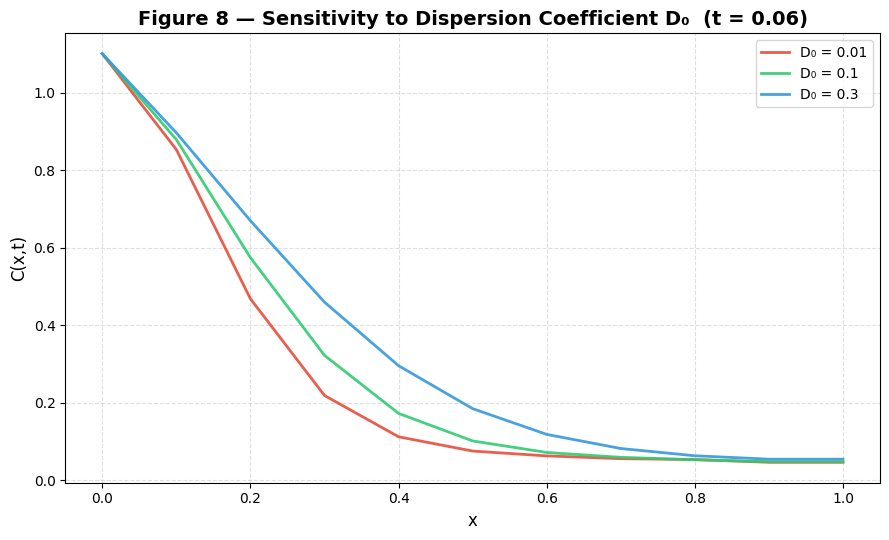

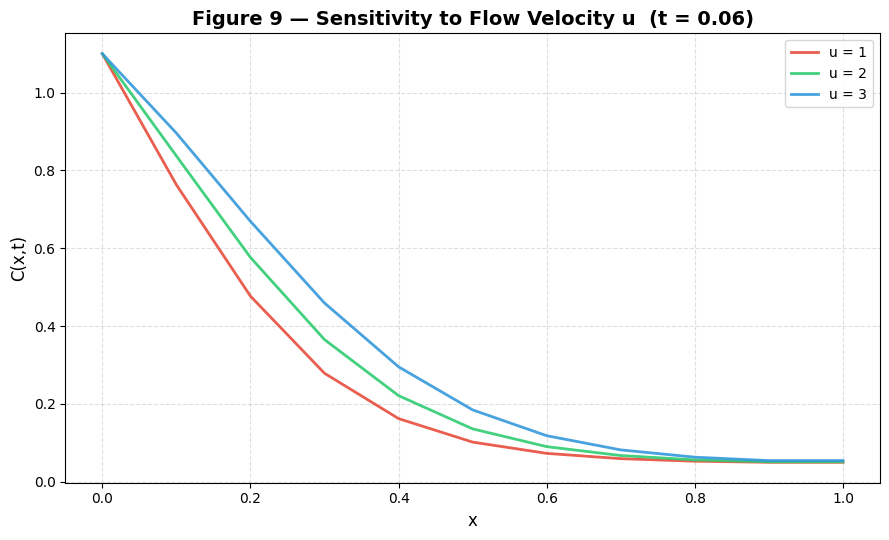

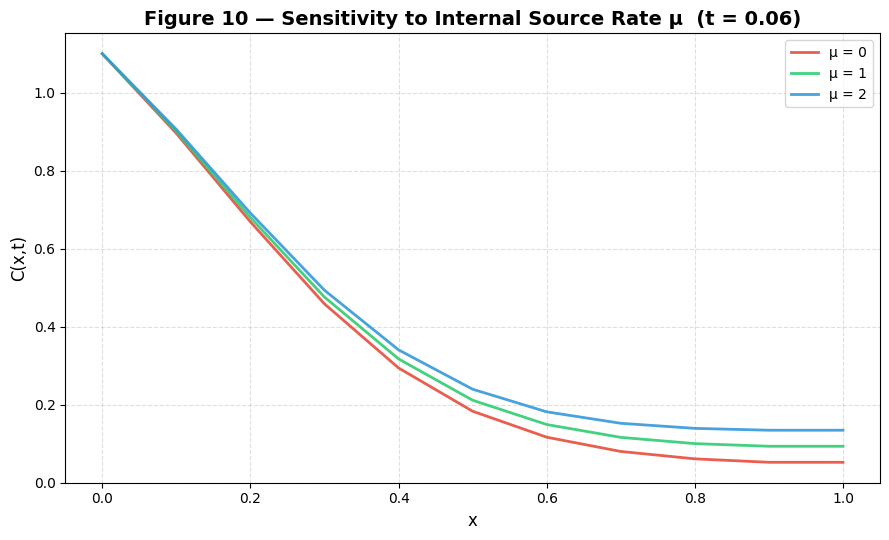

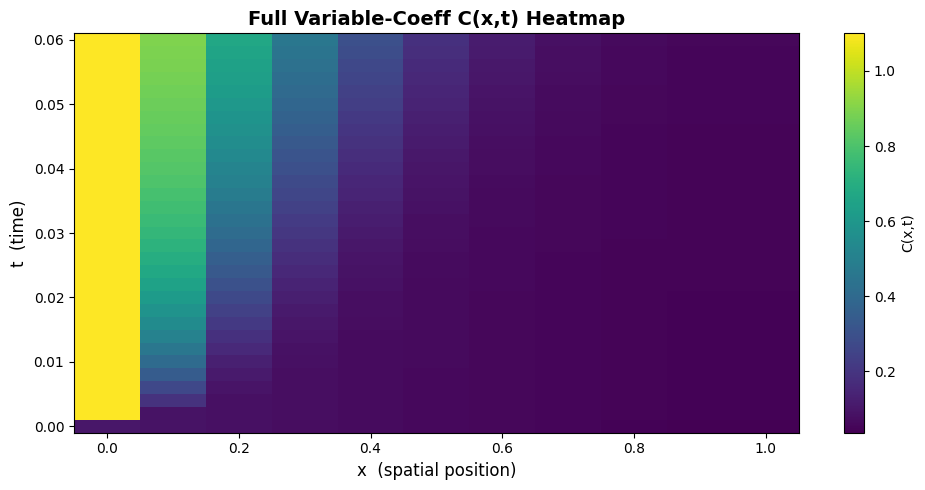


[✓] All plots saved.  Done.


In [3]:
"""
=============================================================================
Solver for the Variable-Coefficient 1D Advection-Diffusion-Decay Equation
=============================================================================
Governing PDE  (Equation 1 from the manuscript):

    dC/dt = d/dx[ D(x) dC/dx ] - d/dx[ V(x) C ] - γ(x) C + S(x)

with spatially varying coefficients (Equation 2):
    V(x) = u (1 + α x)
    D(x) = D₀ (1 + δ x)
    γ(x) = g exp(-β x)
    S(x) = μ (1 - exp(-λ x))

Initial condition  (Eq. 4):  C(x,0) = c₀ exp(-x/k)
Boundary conditions (Eq. 5–6):
    C(0,t) = c₁ + c₂ exp(-w t)
    dC/dx → 0  as x → ∞

Numerical method (Section 4.3):
    Explicit finite-difference scheme — forward in time, central in space.

Analytical solution (Eq. 8):
    Valid ONLY for the constant-coefficient special case
    α = δ = β = 0,  λ → ∞  (i.e. S(x) = μ = const).

--------------------------------------------------------------------------
Author note:  scipy.special.erfc is used for the complementary error
function.  No external PDE library (e.g. deepxde) is required; the scheme
is straightforward enough that raw NumPy + SciPy suffice and keep the code
fully self-contained and easy to audit against the manuscript equations.
=============================================================================
"""

import numpy as np
from scipy.special import erfc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time


# ─────────────────────────────────────────────────────────────────────────────
# 1.  PARAMETER DATACLASS  –  single source of truth for all constants
# ─────────────────────────────────────────────────────────────────────────────
class ADEParams:
    """Container for every scalar in the ADE problem statement."""

    def __init__(
        self,
        # transport
        u: float = 3.0,       # initial flow velocity
        D0: float = 0.3,      # initial dispersion coefficient
        # spatial-variation flags
        alpha: float = 1.0,   # velocity variation coefficient
        delta: float = 1.0,   # dispersion variation coefficient
        beta: float = 1.0,    # decay variation coefficient
        # decay & source
        g: float = 0.4,       # initial decay constant
        mu: float = 0.05,     # internal source rate
        lam: float = 2.0,     # source growth coefficient  (λ)
        # IC / BC
        c0: float = 0.1,      # initial concentration amplitude
        k: float = 1.0,       # spatial decay length in IC
        c1: float = 1.0,      # steady inlet concentration
        c2: float = 0.1,      # transient inlet amplitude
        w: float = 0.001,     # temporal decay rate for inlet pulse
        # grid
        x_max: float = 1.0,   # computational domain end
        t_max: float = 0.06,  # simulation end time
        dx: float = 0.1,      # spatial step
        dt: float = 0.002,    # time step
    ):
        self.u = u;         self.D0 = D0
        self.alpha = alpha; self.delta = delta; self.beta = beta
        self.g = g;         self.mu = mu;       self.lam = lam
        self.c0 = c0;       self.k = k
        self.c1 = c1;       self.c2 = c2;       self.w = w
        self.x_max = x_max; self.t_max = t_max
        self.dx = dx;       self.dt = dt

    # ── derived grid arrays ──────────────────────────────────────────────
    @property
    def x(self):
        return np.arange(0, self.x_max + self.dx / 2, self.dx)

    @property
    def t(self):
        return np.arange(0, self.t_max + self.dt / 2, self.dt)

    @property
    def Nx(self):
        return len(self.x)

    @property
    def Nt(self):
        return len(self.t)


# ─────────────────────────────────────────────────────────────────────────────
# 2.  SPATIALLY VARYING COEFFICIENT FUNCTIONS  (Equation 2)
# ─────────────────────────────────────────────────────────────────────────────
def V(x, p: ADEParams):
    """Flow velocity  V(x) = u (1 + α x)."""
    return p.u * (1 + p.alpha * x)


def D(x, p: ADEParams):
    """Dispersion coefficient  D(x) = D₀ (1 + δ x)."""
    return p.D0 * (1 + p.delta * x)


def gamma(x, p: ADEParams):
    """Decay rate  γ(x) = g exp(-β x)."""
    return p.g * np.exp(-p.beta * x)


def S(x, p: ADEParams):
    """Source term  S(x) = μ (1 - exp(-λ x))."""
    return p.mu * (1 - np.exp(-p.lam * x))


# ─────────────────────────────────────────────────────────────────────────────
# 3.  EXPLICIT FINITE-DIFFERENCE SOLVER  (Section 4.3, Equation 9)
# ─────────────────────────────────────────────────────────────────────────────
def solve_fd(p: ADEParams) -> np.ndarray:
    """
    Forward-in-time, central-in-space explicit FD scheme.

    Returns
    -------
    C : ndarray, shape (Nt, Nx)
        Concentration field on the (t, x) grid.
    """
    x  = p.x
    Nx = p.Nx
    Nt = p.Nt
    dx = p.dx
    dt = p.dt

    # ── stability check (CFL-like) ───────────────────────────────────────
    u_max = np.max(V(x, p))
    D_max = np.max(D(x, p))
    dt_adv = dx / u_max                       # advective CFL
    dt_dif = dx**2 / (2 * D_max)             # diffusive CFL
    dt_stable = min(dt_adv, dt_dif)
    if dt > dt_stable:
        print(f"[WARNING] dt={dt} may exceed stability limit ≈ {dt_stable:.6f}. "
              f"Consider reducing dt.")

    # ── allocate solution array ──────────────────────────────────────────
    C = np.zeros((Nt, Nx))

    # ── initial condition  C(x,0) = c₀ exp(-x/k) ────────────────────────
    C[0, :] = p.c0 * np.exp(-x / p.k)

    # ── time-marching loop ───────────────────────────────────────────────
    for j in range(Nt - 1):
        t_j = j * dt

        # interior points i = 1 … Nx-2
        for i in range(1, Nx - 1):
            xi = x[i]
            Di = D(xi, p)
            Vi = V(xi, p)
            gi = gamma(xi, p)
            Si = S(xi, p)

            # Coefficients r1, r2, r3 from Eq. (9)
            r1 = (Di * dt / dx**2
                  + (Vi - p.D0 * p.delta) * dt / (2 * dx))

            r2 = (1
                  - 2 * Di * dt / dx**2
                  - (p.u * p.alpha + gi) * dt)

            r3 = (Di * dt / dx**2
                  - (Vi - p.D0 * p.delta) * dt / (2 * dx))

            C[j + 1, i] = r1 * C[j, i - 1] + r2 * C[j, i] + r3 * C[j, i + 1] \
                         + Si * dt

        # ── boundary conditions ──────────────────────────────────────────
        # upstream:  C(0, t) = c₁ + c₂ exp(-w t)
        C[j + 1, 0] = p.c1 + p.c2 * np.exp(-p.w * (t_j + dt))

        # downstream (Neumann → copy last interior value):  dC/dx = 0
        C[j + 1, -1] = C[j + 1, -2]

    return C


# ─────────────────────────────────────────────────────────────────────────────
# 4.  ANALYTICAL SOLUTION  (Equation 8)
#     Valid only when α = δ = β = 0  and  λ → ∞  (constant coefficients).
# ─────────────────────────────────────────────────────────────────────────────
def analytical_solution(x, t, p: ADEParams) -> np.ndarray:
    """
    Closed-form solution from Eq. (8).

    Parameters
    ----------
    x, t : array_like
        Spatial and temporal coordinates (scalar or 1-D).
    p    : ADEParams  (only u, D0, g, mu, c0, k, c1, c2, w are used)

    Returns
    -------
    C : ndarray with shape matching (x, t) broadcasting.
    """
    x = np.asarray(x, dtype=float)
    t = np.asarray(t, dtype=float)

    u  = p.u;  D0 = p.D0;  g  = p.g
    mu = p.mu; c0 = p.c0;  k  = p.k
    c1 = p.c1; c2 = p.c2;  w  = p.w

    # ── helper: safe sqrt & erfc wrappers ────────────────────────────────
    def _erfc(z):
        """erfc clamped to avoid overflow in large-argument tails."""
        return erfc(np.clip(z, -26, 26))

    # ── Term 1: steady source response  (μ/g terms) ─────────────────────
    T1 = (mu / g) + (mu / g) * np.exp(-g * t) * (
        -1
        + 0.5 * np.exp(0.0) * _erfc((x - u * t) / (2 * np.sqrt(D0 * t)))
        + 0.5 * np.exp(u * x / D0) * _erfc((x + u * t) / (2 * np.sqrt(D0 * t)))
    )

    # ── Term 2: transient inlet pulse  (c₂ term) ─────────────────────────
    disc_w = 1 + 4 * D0 * (g - w) / u**2
    sqrt_disc_w = np.sqrt(np.maximum(disc_w, 0.0))

    exp_plus_w  = np.exp((u + u * sqrt_disc_w) * x / (2 * D0))
    exp_minus_w = np.exp((u - u * sqrt_disc_w) * x / (2 * D0))

    T2 = c2 * np.exp(-w * t) * (
        0.5 * exp_minus_w * _erfc(
            (x - t * u * sqrt_disc_w) / (2 * np.sqrt(D0 * t))
        )
        + 0.5 * exp_plus_w * _erfc(
            (x + t * u * sqrt_disc_w) / (2 * np.sqrt(D0 * t))
        )
    )

    # ── Term 3: steady inlet  (c₁ − μ/g term) ───────────────────────────
    disc_g = 1 + 4 * g * D0 / u**2
    sqrt_disc_g = np.sqrt(np.maximum(disc_g, 0.0))

    exp_plus_g  = np.exp((u + u * sqrt_disc_g) * x / (2 * D0))
    exp_minus_g = np.exp((u - u * sqrt_disc_g) * x / (2 * D0))

    T3 = (c1 - mu / g) * (
        0.5 * exp_minus_g * _erfc(
            (x - t * u * sqrt_disc_g) / (2 * np.sqrt(D0 * t))
        )
        + 0.5 * exp_plus_g * _erfc(
            (x + t * u * sqrt_disc_g) / (2 * np.sqrt(D0 * t))
        )
    )

    # ── Term 4: initial condition contribution  (c₀ term) ────────────────
    A = D0 * t / k**2 + (t * u - x) / k
    B = D0 * t / k**2 + (t * u + x) / k + u * x / D0

    T4 = np.exp(-g * t) * c0 * (
        np.exp(A)
        - 0.5 * np.exp(A) * _erfc(
            (x - u * t) / (2 * np.sqrt(D0 * t)) - np.sqrt(D0 * t) / k
        )
        - 0.5 * np.exp(B) * _erfc(
            (x + u * t) / (2 * np.sqrt(D0 * t)) + np.sqrt(D0 * t) / k
        )
    )

    return T1 + T2 + T3 + T4


# ─────────────────────────────────────────────────────────────────────────────
# 5.  PLOTTING ROUTINES  (reproduce Figures 6–10 from the manuscript)
# ─────────────────────────────────────────────────────────────────────────────
CMAP   = "viridis"
STYLE  = {"linewidth": 2.0, "alpha": 0.9}


def _shared_ax_labels(ax, xlabel="x", ylabel="C(x,t)"):
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(fontsize=10, loc="best")


# ─── Fig 6: numerical vs analytical (constant-coeff special case) ────────────
def plot_fig6_validation(p_const: ADEParams):
    """Reproduce Fig. 6 — validation of numerical scheme against Eq. (8)."""
    C_num = solve_fd(p_const)
    x     = p_const.x
    t_arr = p_const.t

    target_times = [0.02, 0.04, 0.06]
    colors = ["#e74c3c", "#2ecc71", "#3498db"]

    fig, ax = plt.subplots(figsize=(9, 5.5))
    for tc, col in zip(target_times, colors):
        j_num = int(round(tc / p_const.dt))
        j_num = min(j_num, len(t_arr) - 1)

        # numerical
        ax.plot(x, C_num[j_num, :], color=col, linestyle="-", label=f"Numerical  t={tc}", **STYLE)
        # analytical
        x_fine = np.linspace(x[0] + 1e-8, x[-1], 300)
        C_ana  = analytical_solution(x_fine, tc, p_const)
        ax.plot(x_fine, C_ana, color=col, linestyle="--", label=f"Analytical t={tc}", linewidth=1.5, alpha=0.7)

    ax.set_title("Figure 6 — Validation: Numerical vs Analytical Solution", fontsize=14, fontweight="bold")
    _shared_ax_labels(ax)
    plt.tight_layout()
    plt.savefig("fig6_validation.png", dpi=150)
    plt.show()


# ─── Fig 7: effect of variable D & V ─────────────────────────────────────────
def plot_fig7_variable_DV(p_base: ADEParams):
    """Reproduce Fig. 7 — four scenarios of constant/variable D and V."""
    scenarios = {
        "Const D & Const V":    (0.0, 0.0),
        "Var D   & Const V":    (1.0, 0.0),
        "Const D & Var V  ":    (0.0, 1.0),
        "Var D   & Var V  ":    (1.0, 1.0),
    }
    colors = ["#e74c3c", "#f39c12", "#2ecc71", "#3498db"]
    t_eval = 0.02

    fig, ax = plt.subplots(figsize=(9, 5.5))
    for (label, (delt, alph)), col in zip(scenarios.items(), colors):
        p = ADEParams(
            u=p_base.u, D0=p_base.D0, alpha=alph, delta=delt,
            beta=p_base.beta, g=p_base.g, mu=p_base.mu, lam=p_base.lam,
            c0=p_base.c0, k=p_base.k, c1=p_base.c1, c2=p_base.c2, w=p_base.w,
            x_max=p_base.x_max, t_max=p_base.t_max, dx=p_base.dx, dt=p_base.dt,
        )
        C = solve_fd(p)
        j = int(round(t_eval / p.dt))
        ax.plot(p.x, C[j, :], color=col, label=label, **STYLE)

    ax.set_title("Figure 7 — Effect of Variable Dispersion & Velocity  (t = 0.02)", fontsize=14, fontweight="bold")
    _shared_ax_labels(ax)
    plt.tight_layout()
    plt.savefig("fig7_variable_DV.png", dpi=150)
    plt.show()


# ─── Fig 8: sensitivity to D₀ ────────────────────────────────────────────────
def plot_fig8_D0(p_base: ADEParams):
    """Reproduce Fig. 8 — C(x,t) for D₀ ∈ {0.01, 0.1, 0.3}."""
    D0_values = [0.01, 0.1, 0.3]
    colors    = ["#e74c3c", "#2ecc71", "#3498db"]
    t_eval    = 0.06

    fig, ax = plt.subplots(figsize=(9, 5.5))
    for D0_val, col in zip(D0_values, colors):
        p = ADEParams(
            u=p_base.u, D0=D0_val, alpha=p_base.alpha, delta=p_base.delta,
            beta=p_base.beta, g=p_base.g, mu=p_base.mu, lam=p_base.lam,
            c0=p_base.c0, k=p_base.k, c1=p_base.c1, c2=p_base.c2, w=p_base.w,
            x_max=p_base.x_max, t_max=p_base.t_max, dx=p_base.dx, dt=p_base.dt,
        )
        C = solve_fd(p)
        j = min(int(round(t_eval / p.dt)), p.Nt - 1)
        ax.plot(p.x, C[j, :], color=col, label=f"D₀ = {D0_val}", **STYLE)

    ax.set_title("Figure 8 — Sensitivity to Dispersion Coefficient D₀  (t = 0.06)", fontsize=14, fontweight="bold")
    _shared_ax_labels(ax)
    plt.tight_layout()
    plt.savefig("fig8_D0_sensitivity.png", dpi=150)
    plt.show()


# ─── Fig 9: sensitivity to u ─────────────────────────────────────────────────
def plot_fig9_u(p_base: ADEParams):
    """Reproduce Fig. 9 — C(x,t) for u ∈ {1, 2, 3}."""
    u_values = [1, 2, 3]
    colors   = ["#e74c3c", "#2ecc71", "#3498db"]
    t_eval   = 0.06

    fig, ax = plt.subplots(figsize=(9, 5.5))
    for u_val, col in zip(u_values, colors):
        p = ADEParams(
            u=u_val, D0=p_base.D0, alpha=p_base.alpha, delta=p_base.delta,
            beta=p_base.beta, g=p_base.g, mu=p_base.mu, lam=p_base.lam,
            c0=p_base.c0, k=p_base.k, c1=p_base.c1, c2=p_base.c2, w=p_base.w,
            x_max=p_base.x_max, t_max=p_base.t_max, dx=p_base.dx, dt=p_base.dt,
        )
        C = solve_fd(p)
        j = min(int(round(t_eval / p.dt)), p.Nt - 1)
        ax.plot(p.x, C[j, :], color=col, label=f"u = {u_val}", **STYLE)

    ax.set_title("Figure 9 — Sensitivity to Flow Velocity u  (t = 0.06)", fontsize=14, fontweight="bold")
    _shared_ax_labels(ax)
    plt.tight_layout()
    plt.savefig("fig9_u_sensitivity.png", dpi=150)
    plt.show()


# ─── Fig 10: sensitivity to μ ─────────────────────────────────────────────────
def plot_fig10_mu(p_base: ADEParams):
    """Reproduce Fig. 10 — C(x,t) for μ ∈ {0, 1, 2}."""
    mu_values = [0, 1, 2]
    colors    = ["#e74c3c", "#2ecc71", "#3498db"]
    t_eval    = 0.06

    fig, ax = plt.subplots(figsize=(9, 5.5))
    for mu_val, col in zip(mu_values, colors):
        p = ADEParams(
            u=p_base.u, D0=p_base.D0, alpha=p_base.alpha, delta=p_base.delta,
            beta=p_base.beta, g=p_base.g, mu=mu_val, lam=p_base.lam,
            c0=p_base.c0, k=p_base.k, c1=p_base.c1, c2=p_base.c2, w=p_base.w,
            x_max=p_base.x_max, t_max=p_base.t_max, dx=p_base.dx, dt=p_base.dt,
        )
        C = solve_fd(p)
        j = min(int(round(t_eval / p.dt)), p.Nt - 1)
        ax.plot(p.x, C[j, :], color=col, label=f"μ = {mu_val}", **STYLE)

    ax.set_title("Figure 10 — Sensitivity to Internal Source Rate μ  (t = 0.06)", fontsize=14, fontweight="bold")
    _shared_ax_labels(ax)
    plt.tight_layout()
    plt.savefig("fig10_mu_sensitivity.png", dpi=150)
    plt.show()


# ─── Bonus: 2-D heatmap of the full space-time concentration field ───────────
def plot_heatmap(p: ADEParams, title="C(x,t) — Space-Time Heatmap"):
    C = solve_fd(p)
    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.pcolormesh(p.x, p.t, C, shading="auto", cmap=CMAP)
    ax.set_xlabel("x  (spatial position)", fontsize=12)
    ax.set_ylabel("t  (time)", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    fig.colorbar(im, ax=ax, label="C(x,t)")
    plt.tight_layout()
    plt.savefig("heatmap_full.png", dpi=150)
    plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# 6.  MAIN  –  run everything with the manuscript's default parameters
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":

    # ── (A) Default variable-coefficient parameters (Section 8.4.2) ──────
    p_var = ADEParams(
        u=3.0, D0=0.3,
        alpha=1.0, delta=1.0, beta=1.0,
        g=0.4, mu=0.05, lam=2.0,
        c0=0.1, k=1.0, c1=1.0, c2=0.1, w=0.001,
        x_max=1.0, t_max=0.06, dx=0.1, dt=0.002,
    )

    # ── (B) Constant-coefficient special case for analytical validation ──
    #        α = δ = β = 0,  λ → ∞  ⟹  S(x) ≈ μ (constant)
    p_const = ADEParams(
        u=3.0, D0=0.3,
        alpha=0.0, delta=0.0, beta=0.0,
        g=0.4, mu=0.05, lam=1e6,          # λ → ∞  makes S(x) ≈ μ
        c0=0.1, k=1.0, c1=1.0, c2=0.1, w=0.001,
        x_max=1.0, t_max=0.06, dx=0.1, dt=0.002,
    )

    print("=" * 70)
    print(" ADE Solver — Variable-Coefficient Advection-Diffusion-Decay")
    print("=" * 70)

    # ─── Solve & time the variable-coefficient case ─────────────────────
    t0 = time.perf_counter()
    C_var = solve_fd(p_var)
    elapsed = time.perf_counter() - t0
    print(f"\n[1] Variable-coeff FD solve completed in {elapsed:.4f} s")
    print(f"    Grid: Nx={p_var.Nx}, Nt={p_var.Nt}  |  "
          f"C range: [{C_var.min():.6f}, {C_var.max():.6f}]")

    # ─── Solve the constant-coeff case ───────────────────────────────────
    t0 = time.perf_counter()
    C_const = solve_fd(p_const)
    elapsed = time.perf_counter() - t0
    print(f"\n[2] Constant-coeff FD solve completed in {elapsed:.4f} s")

    # ─── Quick L2 error vs analytical at t = 0.06 ────────────────────────
    x_grid   = p_const.x[1:]          # skip x=0 (boundary, not interior)
    j_final  = p_const.Nt - 1
    C_num    = C_const[j_final, 1:]
    C_ana    = analytical_solution(x_grid, p_const.t_max, p_const)
    l2_err   = np.sqrt(np.mean((C_num - C_ana) ** 2))
    linf_err = np.max(np.abs(C_num - C_ana))
    print(f"\n[3] Validation (constant-coeff, t={p_const.t_max}):")
    print(f"    L2 error  = {l2_err:.6e}")
    print(f"    L∞ error  = {linf_err:.6e}")

    # ─── Generate all figures ────────────────────────────────────────────
    print("\n[4] Generating figures …")
    plot_fig6_validation(p_const)
    plot_fig7_variable_DV(p_var)
    plot_fig8_D0(p_var)
    plot_fig9_u(p_var)
    plot_fig10_mu(p_var)
    plot_heatmap(p_var, title="Full Variable-Coeff C(x,t) Heatmap")

    print("\n[✓] All plots saved.  Done.")